# initialize the NUImages dataset

In [2]:
from nuimages import NuImages

nuim = NuImages(dataroot='nuimages', version='v1.0-train', verbose=True, lazy=True)

Loading nuImages tables for version v1.0-train...
Done loading in 0.000 seconds (lazy=True).


## Get total images

In [3]:
samples = nuim.sample
TOTAL_IMAGES = len(nuim.sample)
print("Total images:", TOTAL_IMAGES)

Loaded 67279 sample(s) in 0.201s,
Total images: 67279


## Try rendering roads

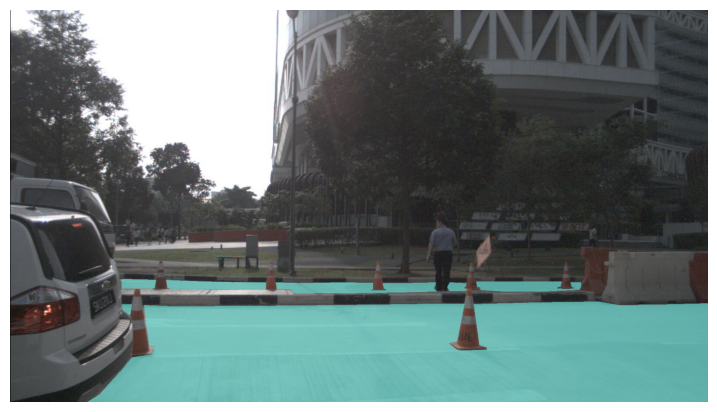

In [30]:
sample_idx = 567

def render(index, annotated=True):
    sample = nuim.get('sample', samples[index]['token'])
    key_camera_token = sample['key_camera_token']
    nuim.render_image(key_camera_token, annotation_type='surfaces' if annotated else 'none')

render(sample_idx, annotated=True)

## Functions for getting road segmentations

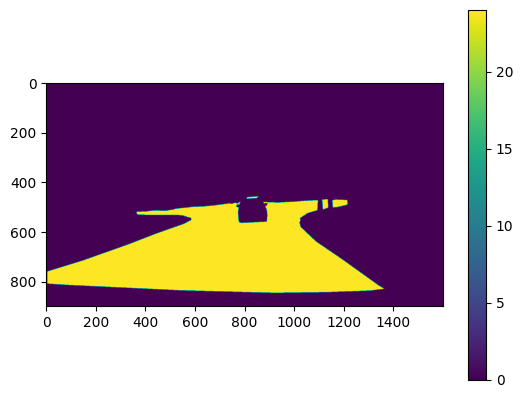

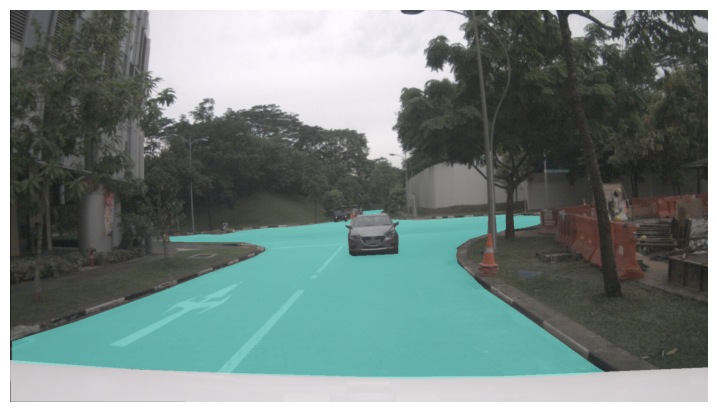

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from functools import lru_cache
import os
from numba import njit

@njit
def remove_everything_else(semantic_mask):
    # Use a JIT-compiled loop for maximum performance
    for i in range(semantic_mask.shape[0]):
        for j in range(semantic_mask.shape[1]):
            if semantic_mask[i, j] != 24:
                semantic_mask[i, j] = 0
    return semantic_mask

@lru_cache(maxsize=256) 
def get_sample(token):
    return nuim.get('sample', token)

@lru_cache(maxsize=256)
def get_segmentation_from_token(token):
    return nuim.get_segmentation(token)

def get_segmentation(index):
    key_camera_token = get_sample(samples[index]['token'])['key_camera_token']
    semantic_mask, _ = get_segmentation_from_token(key_camera_token)
    semantic_mask = remove_everything_else(semantic_mask)
    return key_camera_token, semantic_mask

def show_image_and_annotation(index, semantic_mask):
    plt.imshow(semantic_mask)
    plt.colorbar()
    plt.show()
    render(index, annotated=True)

sample_idx = 88
token, semantic_mask = get_segmentation(sample_idx)
show_image_and_annotation(sample_idx, semantic_mask)

# Functions for saving and loading arrays from files.
## (Just in case)

In [32]:
def save_annotation(filename:int, arr:np.array):
    np.save(f'ann/{filename}.npy', arr)

def load_annotation(filename:int):
    return np.load(f'ann/{filename}.npy')

## Create dataloader

In [40]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import rand
import os
from PIL import Image

image_to_tensor = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the image to 512x512
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

resize_mask_to_tensor = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.ToTensor()           # Convert to PyTorch Tensor
])

def show_tensor(tensor):
    # Convert tensor to NumPy array
    # Transpose from (C, H, W) to (H, W, C) for displaying
    image_np = tensor.permute(1, 2, 0).numpy()
    # Display the image
    plt.imshow(image_np)
    plt.show()

class NuScenesDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        return len(samples)

    def get_raw_data(self, idx):
        # get the mask
        chosen_sample = nuim.get('sample', samples[idx]['token']) #get sample
        token_from_index = chosen_sample['key_camera_token'] # get token of mask from sample
        mask, _ = get_segmentation_from_token(token_from_index) # get segmentation from token
        mask[mask != 24] = 0 # 24 is the id for the road segmentations
        # get the image
        sample_data = nuim.get('sample_data', token_from_index) # get image file name
        im_path = os.path.join("nuimages", sample_data['filename']) # get full image path
        image = Image.open(im_path) 
        return image, mask

    def __getitem__(self, idx):
        image, mask = self.get_raw_data(idx)
        image_mask = Image.fromarray(mask) # convert raw data to tensors (resize to 512x512, convert to tensor)
        return image_to_tensor(image), (resize_mask_to_tensor(image_mask) != 0).float() # for the mask, change all instances of 24 to 1

# Create Dataset and DataLoader
dataset = NuScenesDataset()
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

## Try out the dataset
#### This uses the dataset to load a random image and mask

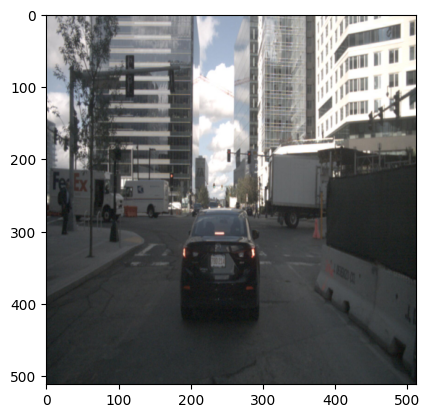

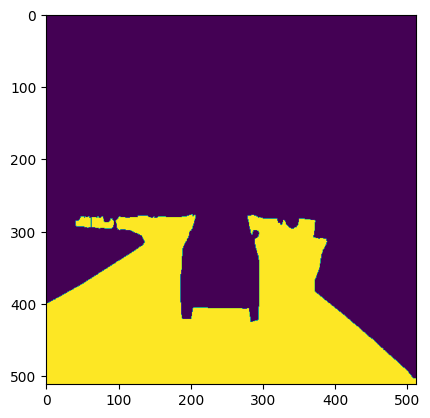

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


In [46]:
import random

random_index = random.randint(0, TOTAL_IMAGES)
image, mask = dataset[random_index]
image_raw, mask_raw = dataset.get_raw_data(random_index)

show_tensor(image)
show_tensor(mask)
print(mask)

# Define model and custom head for training

In [17]:
import torch
from torchvision import models
from torch import nn
# Load a pretrained DeepLabV3+ model with a ResNet-101 backbone
#model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model = models.segmentation.fcn_resnet101(pretrained=True)

model.eval()  # Set the model to evaluation mode

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
import torch.optim as optim
import torch.nn as nn

torch.cuda.empty_cache()

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Performing on device:", device)

model.to(device)
model.train()

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    for image, mask in dataloader:
        image, mask = image.to(device), mask.to(device)

        optimizer.zero_grad()
        output = model(image)['out']

        predicted_segmentation = torch.argmax(output, dim=1, keepdim=True).to(device)
        print(image.shape, output.shape, predicted_segmentation.shape)
        loss = criterion(binaryTensor(predicted_segmentation), mask)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}")

Performing on device: cpu


## Training failed here due to low memory, will try again